# Gliederung
1. [Setup](#setup)
    1. [Librarys](#librarys)
2. [Informationen](#informationen)
3. [Einleitung](#einleitung)
    1. [Fragestellung](#fragestellung)
    2. [Erwartung A Luca Di Palma](#erwartung_a)
    3. [Erwartung B Patrick Langkau](#erwartung_b)
4. [Imports](#imports)
5. [Bereiningung des output Ordners](#bereiningung_des_output_Ordners)
6. [Reading CSV](#reading_csv)
7. [Renaming](#renaming)
8. [Removing unused Values](#removing_unused_values)
9. [Removing duplicates](#removing_duplicates)
10. [Convert Units & Round](#convert_units_and_round)
11. [Merging](#merging)
    1. [Merged Table](#merged_table)
12. [Boxplots](#boxplots)
    1. [Boxplot GDP](#boxplot_gdp)
    2. [Boxplot Mobile Speed](#boxplot_mobile_speed)
    3. [Boxplot Broadband Speed](#boxplot_broadband_speed)
    4. [Boxplot Happiness Score](#boxplot_happiness_score)
    5. [Boxplot Unemployment](#boxplot_unemployment)
    6. [Boxplot Internet Access](#boxplot_internet_access)
    7. [Boxplot Military Spending](#boxplot_military_spending)
13. [Scatterplots](#scatterplots)
    1. [GDP - Broadband Speed](#gdp_broadband_speed)
    2. [GDP - Mobile Speed](#gdp_mobile_speed)
    3. [Internet Access - Mobile Speed](#internet_access_mobile_speed)
    4. [Internet Access - Broadband Speed](#internet_access_broadband_speed)
    5. [Unemployment - Mobile Speed](#unemployment_mobile_speed)
    6. [Unemployment - Broadband Speed](#unemployment_broadband_speed)
    7. [Military Spending - Broadband Speed](#military_spending_broadband_speed)
    8. [Military Spending - Mobile Speed](#military_spending_mobile_speed)
    9. [Happiness Score - Mobile Speed](#happiness_score_mobile_speed)
    10. [Happiness Score - Broadband Speed](#happiness_score_broadband_speed)
14. [NaN Percentege](#nan_percentege)
15. [Pairplots](#pairplots)
    1.[Pairplot - Mobile Speed](#pairplot_mobile_speed)
    2.[Pairplot - Broadband Speed](#pairplot_broadband_speed)
16. [Adjusting tmpMobile](#adjusting_tmpmobile)
17. [Adjusting tmpBroadband](#adjusting_tmpbroadband)
18. [Mobile Speed Neural Net](#mobile_speed_neural_net)
    1. [Mobile Speed - Deep Learning](#mobile_speed_deep_learning)
    2. [Mobile Speed - Over Average](#mobile_speed_over_average)
    3. [Mobile Speed - Under Average](#mobile_speed_under_average)
    4. [Vergleich Mobile Speed Over Average/Under Average](#vergleich_mobile_speed_over_average_under_average)
    5. [Mobile Speed - Neural Network Visualisation](#mobile_speed_neural_network_visualisation)
19. [Broadband Speed Neural Net](#broadband_speed_neural_net)
    1. [Broadband Speed - Deep Learning](#broadband_speed_deep_learning)
    2. [Broadband Speed - Over Average](#broadband_speed_over_average)
    3. [Broadband Speed - Under Average](#broadband_speed_under_average)
    4. [Vergleich Broadband Speed Over Average/Under Average](#vergleich_broadband_speed_over_average_under_average)
    5. [Broadband Speed - Neural Network Visualisation](#broadband_speed_neural_network_visualisation)
20. [Welt Ansichten](#welt_ansichten)
    1. [Welt - Broadband Speed](#welt_broadband_speed)
    2. [Welt - Mobile Speed](#welt_mobile_speed)
21. [Quellen](#quellen)

<a id='setup'></a>
# 1. Setup

<a id='librarys'></a>
### 1.A. Librarys:
Sie müssen die folgenden Kommandos ausführen, um die für dieses Programm benötigten Librarys zu installieren
#### pip install matplotlib
#### pip install numpy
#### pip install pandas
#### pip install seaborn
#### pip install keras
#### pip install sklearn
#### pip install tensorflow
#### pip install plotly

<a id='informationen'></a>
# 2. Informationen
Die Aufteilung in diesem Dokument wurde so vorgenommen, dass Luca Di Palma den Vergleich der Daten mit der Mobilen Internet Geschwindigkeit übernommen hat und Patrick Langkau den Vergleich mit der Breitband Geschwindigkeit. In jedem Abschnitt wird der Author explizit genannt

Der Code muss, um korrekt zu funktionieren, komplett ausgeführt werden. Eine Einzelausführung mancher Zellen kann unerwünschte Ergebnisse hervorbringen.

Bitte lassen Sie keine Diagramme aus dem output Ordner geöffnet wenn Sie den Code ausführen, dies kann zu Fehlern führen.

Alle erstellten Diagramme sind auch im Ordner ../output/ zu finden

<a id='einleitung'></a>
# 3. Einleitung
<a id='fragestellung'></a>
### 3.A. Fragestellung
Ein Phänomen dessen Einfluss die ganze Welt verändert hat: Das Internet. Ohne es würde die ganze Infrastruktur der Welt zusammenstürzen und den Fortschritt der Menschheit einige Jahrzehnte zurückwerfen. Doch obwohl die ganze Welt miteinander vernetzt ist, hat nicht jedes Land die gleichen Möglichkeiten, das Internet zu benutzen. So Unterscheiden sich die Länder in vielen verschiedenen Faktoren. Z.B. wie gut der Zugriff auf das Internet ist oder auch wie hoch die Arbeitslosigkeit in einem Land möglicherweise dessen Ausbau verhindert. Doch welche Faktoren haben einen Einfluss die mobile und die Breitbandgeschwindigkeit? Im Folgenden werden Faktoren mit der Internetgeschwindigkeit in Korrelation gebracht, die möglicherweise einen Einfluss darauf haben, wie schnell das Internet im jeweiligen Land ist.

<a id='erwartung_a'></a>
### 3.B. Erwartung A (Luca Di Palma)
###### - Es wird vermutet, dass die Internetgeschwindigkeit abhängig von verschiedenen Faktoren wie z.B. der wirtschaftlichen Lage, dem Wohlbefinden der Bürger, oder dem Zugang zum Internet ist.
###### - Ein höherer Happiness Score lässt eine schnellere Internetverbindung Vermuten
Eine gute Internetverbindung kann ein Faktor dafür sein, dass die Bürger eines Landes glücklicher sind. Die gute Vernetzung kann einen positiven Einfluss auf die sozialen Kontakte haben, wenn z.B. Familien oder auch Freunde die nicht in unmittelbare Nähe beieinander wohnen dennoch gut miteinander kommunizieren können.

###### - Je höher die Militärausgaben, desto höher ist vermutlich auch die Internetgeschwindigkeit
Durch eine höhere Militarisierung muss das Militär im Land gut und schnell vernetzt sein. Diese Infrastruktur könnte den Bürgern des Landes teilweise zur Verfügung gestellt werden.

<a id='erwartung_b'></a>
### 3.C. Erwartungen B (Patrick Langkau)
###### - Eine Bessere wirtschaftliche Lage eines Landes, lässt eine höhere Internetgeschwindigkeit erwarten.
###### - Wo ein höherer Prozentsatz der Menschen Zugriff auf das Internet hat, wird auch eine höhere Internetgeschwindigkeit erwartet.
###### - Es wird erwartet, dass eine niedrigere Arbeitslosigkeit dazu führt, das mehr Personen Zugang zum Internet haben.


<a id='imports'></a>
# 4. Imports (Luca Di Palma, Patrick Langkau)
Da die Imports von Luca Di Palma, sowie von Patrick Langkau benötigt werden, wurden diese im folgenden Code Block zu einem Abschnitt zusammengefasst.

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
import pandas as pd
import seaborn as sns
import tensorflow
import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import shutil
import os

<a id='bereiningung_des_output_Ordners'></a>
# 5. Bereinigung des output ordners
In diesem Codeblock wird der output Ordner bereinigt. In dem output Ordnern werden später alle Diagramme als Bildformat png gespeichert. Das soll verhindern, dass bei Änderungen der Grafiken konflikte entstehen.

In [88]:
for root, dirs, files in os.walk('..\output'):
    for f in files:
        os.unlink(os.path.join(root, f))
    for d in dirs:
        shutil.rmtree(os.path.join(root, d))
open('..\output\.gitkeep', 'a').close()

# Visualize Neural Network Function (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)

In [89]:
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0,
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units,
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0,
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

def visualize_nn(model, filename, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]

    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025

    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color

        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)

        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)

            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')

    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left],
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space],
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.savefig(fr'..\output\{filename}.png')
    plt.show()

<a id='reading_csv'></a>
# 6. Reading CSV
Im ersten Schritt ist Reading CSV ist dafür verantwortlich, die CSV-Dateien mit den Daten der einzelnen Datensätze so zu bearbeiten, dass sie ohne Kommas und Semikolons in Variablen gespeichert werden. Im zweiten Schritt werden diese Daten in Dataframes (Zweidimensionale Tabellen) gespeist. Dabei werden nur relevante Daten, wie z.B. bestimmte Jahre der Datenerhebung, für die Erstellung der Dataframes eingelesen.

In [90]:
gdp_data = pd.read_csv(r'..\gdp_csv.csv')
internet_speed_data = pd.read_csv(r'..\internet_speeds.csv', sep=";")
internet_access_data = pd.read_csv(r'..\internet_access.csv')
unemployment_data = pd.read_csv(r'..\unemployment.csv', on_bad_lines='skip')
military_data = pd.read_csv(r'..\military_expenditure.csv')
happy_data = pd.read_csv(r'..\world_happiness_report_2022.csv', decimal=",", sep=";")
country_codes_data = pd.read_csv(r'..\country_codes.csv', sep=";")

gdp = pd.DataFrame(gdp_data, columns=['Country Code', 'Value', 'Year'])
internet_speed = pd.DataFrame(internet_speed_data, columns=['Country','Broadband Mbps', 'Mobile Mbps', 'As of'])
internet_access = pd.DataFrame(internet_access_data, columns=['Country Code', '2020'])
unemployment = pd.DataFrame(unemployment_data, columns=['Country Code','2021'])
military = pd.DataFrame(military_data, columns=['Code', '2018'])
happy = pd.DataFrame(happy_data, columns=['Country', 'Happiness score'])
country_codes = pd.DataFrame(country_codes_data, columns=['Country', 'Alpha-3 code'])

<a id='renaming'></a>
# 7. Renaming
In Renaming werden die Spalten der zuvor eingelesenen relevanten Daten umbenannt. Dies dient dazu, die Dataframes später für den menschlichen Leser überschaubarer und einfacher lesbar zu machen.

In [91]:
gdp.rename(columns = {'Country Code':'CountryCode', 'Year':'YearGDP', 'Value':'GDP'}, inplace = True)
internet_speed.rename(columns = {'Country':'CountryName', 'Broadband Mbps':'BroadbandSpeed', 'Mobile Mbps':'MobileSpeed', 'As of':'YearInternetSpeed'}, inplace = True)
internet_access.rename(columns={'Country Code':'CountryCode', '2020':'InternetAccess2020'}, inplace= True)
unemployment.rename(columns= {'Country Code':'CountryCode', '2021':'Unemployment2021'}, inplace=True)
military.rename(columns= {'Code':'CountryCode', '2018':'MilitarySpending2018'}, inplace=True)
happy.rename(columns= {'Country':'CountryName', 'Happiness score':'HappinessScore2022'}, inplace=True)
country_codes.rename(columns= {'Alpha-3 code':'CountryCode', 'Country':'CountryName'}, inplace=True)

<a id='removing_unused_values'></a>
# 8. Removing unused Values
In diesem Codeblock werden ungenutzte Werte des Happiness Datensatzes entfernt. Damit sind Sterne ("*") im Datensatz gemeint, die bei manchen Ländern in der Spalte "CountryName" vorhanden sind. Diese werden entfernt, um die richtigen Ländercodes aus dem Datensatz country_codes zuordnen zu können.

In [92]:
country_codes['CountryCode'] = country_codes['CountryCode'].replace({'"':''}, regex=True)
happy['CountryName'] = happy['CountryName'].replace({'\*':''}, regex=True)

<a id='removing_duplicates'></a>
# 9. Removing Duplicates
In den Daten von GDP und Internet_speeds befinden sich Duplikate. Um keine Redundanz zu erzeugen, werden zunächst alle Daten der beiden Datensätze nach Land und Jahr sortiert. Sollten Duplikate bestehen, werden diese direkt aufeinander folgen. Nun werden, bis auf den Wert der an oberster Stelle steht, Daten gelöscht, deren Ländercodes mehrmals vorkommen.

In [93]:
gdp.sort_values(by=['CountryCode','YearGDP'], ascending=False, inplace=True)
internet_speed.sort_values(by=['CountryName','YearInternetSpeed'], ascending=False, inplace=True)

gdp.drop_duplicates(subset=['CountryCode'], keep='first', inplace=True)
internet_speed.drop_duplicates(subset=['CountryName'], keep='first', inplace=True)

<a id='convert_units_and_round'></a>
# 10. Convert Units & Round (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
Da bei den Daten von GDP und military_expenditure extrem große Zahlen bestehen, werden diese in eine andere Darstellung konvertiert und gerundet. „GDP“-Werte in gdp werde durch 1.000.000.000 (eine Milliarde) geteilt und auf 2 (zwei) Nachkommastellen gerundet. „MilitarySpending2018“-Werte in military_expenditure werden durch 1.000.000 (eine Million) geteilt und auf 2 (zwei) Nachkommastellen gerundet.

In [94]:
gdp['GDP'] = gdp['GDP'].div(1000000000).round(2)
military['MilitarySpending2018'] = military['MilitarySpending2018'].div(1000000).round(2)

<a id='merging'></a>
# 11. Merging (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
Nun werden alle Daten miteinander verschmolzen. Dafür werden alle DataFrames mittels left-Joins miteinander verbunden. Vorangehende und folgende Leerzeichen werden entfernt. Schlussendliche entsteht ein Dataset, in dem alle relevanten Daten vorhanden sind. Im Folgenden werden 20 Daten dieses Datasets als Tabelle ausgegeben.

In [95]:
internet_speed = pd.merge(internet_speed, country_codes, how='left', on='CountryName')
happy = pd.merge(happy, country_codes, how='left', on='CountryName')
happy.drop('CountryName', axis=1, inplace=True)
internet_speed['CountryCode'] = internet_speed['CountryCode'].str.strip()
happy['CountryCode'] = happy['CountryCode'].str.strip()
internet_access['CountryCode'] = internet_access['CountryCode'].str.strip()
unemployment['CountryCode'] = unemployment['CountryCode'].str.strip()
military['CountryCode'] = military['CountryCode'].str.strip()
dataset = pd.merge(internet_speed, gdp, how='left', on = 'CountryCode')
dataset = pd.merge(dataset, internet_access, how='left', on='CountryCode')
dataset = pd.merge(dataset, unemployment, how='left', on='CountryCode')
dataset = pd.merge(dataset, military, how='left', on='CountryCode')
dataset = pd.merge(dataset, happy, how='left', on='CountryCode')
dataset.head(80)

,CountryName,BroadbandSpeed,MobileSpeed,YearInternetSpeed,CountryCode,GDP,YearGDP,InternetAccess2020,Unemployment2021,MilitarySpending2018,HappinessScore2022
0,Zimbabwe,5.21,12.02,January 2022,ZWE,16.62,2016.0,29.300000,5.174,420.36,2.995
1,Zambia,4.60,12.46,January 2022,ZMB,21.06,2016.0,19.800000,13.026,378.03,3.760
2,Yemen,2.74,0.53,January 2022,YEM,27.32,2016.0,NaN,13.574,NaN,4.197
3,Western Sahara,10.51,NaN,January 2022,ESH,NaN,NaN,NaN,NaN,NaN,NaN
4,Vietnam,67.50,39.01,January 2022,VNM,205.28,2016.0,70.300000,2.166,5500.00,5.485
...,...,...,...,...,...,...,...,...,...,...,...
75,Micronesia,9.75,NaN,January 2022,FSM,0.33,2016.0,NaN,NaN,NaN,NaN
76,Mexico,38.77,22.26,January 2022,MEX,1046.92,2016.0,71.968194,4.379,6567.51,6.128
77,Mauritius,19.88,20.59,January 2022,MUS,12.17,2016.0,64.884904,7.414,23.20,6.071
78,Mauritania,6.10,NaN,January 2022,MRT,4.74,2016.0,40.800000,11.463,159.01,4.153


<a id='merged_table'></a>
# 11.1 Merged Table
In dieser Tabelle werden nun alle Daten und die zugehörigen Länder ausgegeben. Werte die "NaN" sind, sind nicht vorhanden. Sortiert wurden die Länder von Z-A. So sind die Daten, aus denen die Internetgeschwindigkeiten gemessen wurden, alle vom Januar 2022. Bei den GDPs wurden immer die zuletzt veröffentlichen Zahlen und das Jahr angegeben. Internet Access Daten sind aus dem Jahr 2020, Unemployment Daten aus dem Jahr 2021. Die Daten zum Military Spending sind aus dem Jahr 2018, der Happiness Score ist am aktuellsten, die Daten sind aus dem Jahr 2022.

<a id='boxplots'></a>
# 12. Boxplots
Bei einem Boxplot handelt es sich um ein Diagramm, welches die Verteilung eines Merkmals grafisch darstellt. Dieses Merkmal muss mindestens ordinal skaliert sein. Oft wird auch der Begriff Box-Whisker-Plot benutzt. Im Diagramm soll einfach dargestellt werden, in welchem Bereich die Daten liegen und wie sie sich verteilen. So besteht der Boxplot aus 5 Merkmalen: Dem unteren Whisker, dem unteren Quartil, dem Median, dem oberen Quartil und dem oberen Whisker. Innerhalb der Box, also zwischen oberem und unterem Quartil, befinden sich 50 % der Daten. Innerhalb der Box ist ein Strich zu finden, er stell den Median dar.

<a id='boxplot_gdp'></a>
# 12.1 Boxplot GDP (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
In diesem Diagramm werden die Daten der GDPs der verschiedenen Länder veranschaulicht. Angegeben sind die Daten in Milliarden USD. Dieser Boxplot hat als einer von zwei nicht die Punkte eingezeichnet, die die einzelnen Länder repräsentieren sollen. Das liegt daran, dass die Unterschiede zu groß sind und der Boxplot nicht mehr richtig lesbar ist.

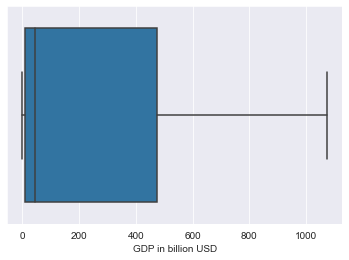

In [96]:
plotBroadBand = sns.boxplot(x=gdp['GDP'], showfliers = False)
#plotBroadBand = sns.swarmplot(x=gdp['GDP'], color="r")
plotBroadBand.set(
    xlabel='GDP in billion USD'
)
plotBroadBand.get_figure().savefig(r'..\output\GDP Boxplot.png')
plt.show()

Die Hälfte der Länder hat einen GDP zwischen ~0 und ~500 Milliarden USD. Der obere Whisker geht dennoch bis fast 1100.

<a id='boxplot_mobile_speed'></a>
# 12.2 Boxplot Mobile Speed (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
In diesem Diagramm wird der Boxplot zur mobilen Internetgeschwindigkeit dargestellt. Jeder rote Punkt repräsentiert ein Land. Die Daten sind in Mbps angegeben.

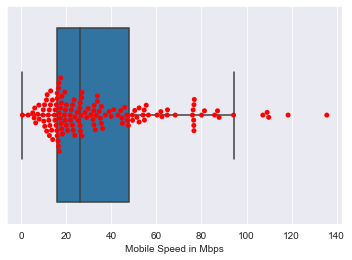

In [97]:
plotBroadBand = sns.boxplot(x=dataset['MobileSpeed'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['MobileSpeed'], color="r")
plotBroadBand.set(
    xlabel='Mobile Speed in Mbps'
)
plotBroadBand.get_figure().savefig(r'..\output\Mobile Speed Boxplot.png')
plt.show()

50 % der Länder haben eine mobile Internetgeschwindigkeit zwischen ~15 und ~50 Mbps. Auffällig ist eine Ansammlung vieler Länder am unteren Quartil, sowohl außerhalb als auch innerhalb der Box. Außerhalb der Box findet sich eine weitere auffällige Ansammlung von Ländern bei ~75 Mbps. Die Verteilung der Länder ist hier zu Anfang bei weniger Geschwindigkeit breiter gefächert. Je höher die mobile Internetgeschwindigkeit ist, desto weniger Länder sind im Diagramm zu sehen.

<a id='boxplot_broadband_speed'></a>
# 12.3 Boxplot Broadband Speed (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
In diesem Diagramm wird der Boxplot zur Breitbandgeschwindigkeit dargestellt. Jeder rote Punkt repräsentiert ein Land. Die Daten sind in Mbps angegeben.

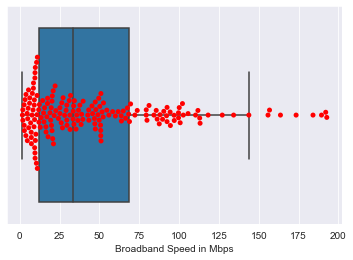

In [98]:
plotBroadBand = sns.boxplot(x=dataset['BroadbandSpeed'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['BroadbandSpeed'], color="r")
plotBroadBand.set(
    xlabel='Broadband Speed in Mbps'
)
plotBroadBand.get_figure().savefig(r'..\output\Broadband Speed Boxplot.png')
plt.show()

50 % der Länder haben eine Breitbandgeschwindigkeit zwischen ~12 und ~70 Mbps. Auffällig ist eine große Ansammlung von Länder vor dem unteren Quartil. Diese Länder befinden sich nicht in der Box. Die Verteilung der Länder ist hier zu Anfang bei weniger Geschwindigkeit breiter gefächert. Je höher die Breitbandgeschwindigkeit ist, desto weniger Länder sind im Diagramm zu sehen.

<a id='boxplot_happiness_score'></a>
# 12.4 Happiness Score Boxplot (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
In diesem Diagramm wird der Boxplot zum Happiness Score dargestellt. Jeder rote Punkt repräsentiert ein Land.

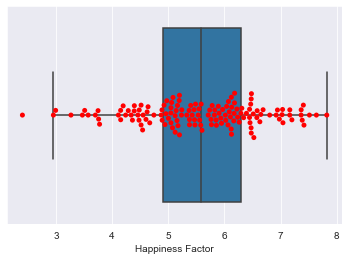

In [99]:
plotBroadBand = sns.boxplot(x=dataset['HappinessScore2022'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['HappinessScore2022'], color="r")
plotBroadBand.set(
    xlabel='Happiness Factor'
)
plotBroadBand.get_figure().savefig(r'..\output\Happiness Boxplot.png')
plt.show()

50 % der Länder haben einen Happiness Score zwischen ~4,9 und ~6,3. Im Gegensatz zu den Internetgeschwindigkeiten, sind hier keine Auffällig großen Ansammlung von Ländern bei einem bestimmt Happiness Score. Des Weiteren gibt es nur einen Ausreißer, der unter dem unteren Whisker ist.

<a id='boxplot_unemployment'></a>
# 12.5 Unemployment Boxplot (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
In diesem Diagramm wird der Boxplot zur Arbeitslosigkeit dargestellt. Jeder rote Punkt repräsentiert ein Land. Die Daten sind in % angegeben.

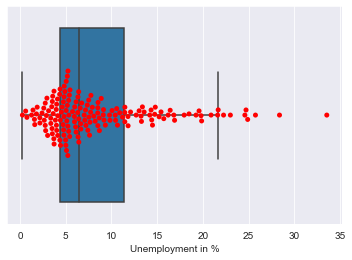

In [100]:
plotBroadBand = sns.boxplot(x=dataset['Unemployment2021'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['Unemployment2021'], color="r")
plotBroadBand.set(
    xlabel='Unemployment in %'
)
plotBroadBand.get_figure().savefig(r'..\output\Unemployment Boxplot.png')
plt.show()

50 % der Länder haben eine Arbeitslosenquote zwischen ~4 und ~12 %. Eine große Ansammlung an Länder findet sich am unteren Quartil. So befinden sich bei 0 % wenige Länder, je weiter es gegen 5 % läuft desto mehr Länder werden es. Ab 5 % ist die Anzahl an Ländern wieder abnehmend.

<a id='boxplot_internet_access'></a>
# 12.6 Internet Access Boxplot (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
In diesem Diagramm wird der Boxplot zum Internet Access dargestellt. Jeder rote Punkt repräsentiert ein Land. Die Daten sind in % angegeben.

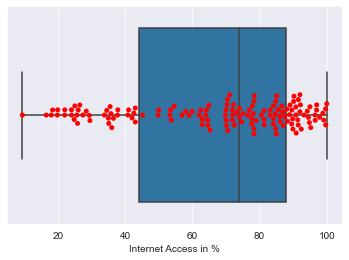

In [101]:
plotBroadBand = sns.boxplot(x=dataset['InternetAccess2020'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['InternetAccess2020'], color="r")
plotBroadBand.set(
    xlabel='Internet Access in %'
)
plotBroadBand.get_figure().savefig(r'..\output\Internet Access Boxplot.png')
plt.show()

50 % der Länder haben einen Internet Acces zwischen ~42 und ~88 %. Auffällig hier ist eine große Ansammlung an Ländern zwischen ~70 und 100 %.

<a id='boxplot_military_spending'></a>
# 12.7 Military Spending Boxplot (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
In diesem Diagramm werden die Daten der Militärausgaben der verschiedenen Länder veranschaulicht. Angegeben sind die Daten in Millionen USD. Dieser Boxplot hat als zweiter von zwei nicht die Punkte eingezeichnet, die die einzelnen Länder repräsentieren sollen. Das liegt daran, dass die Unterschiede zu groß sind und der Boxplot nicht mehr richtig lesbar ist.

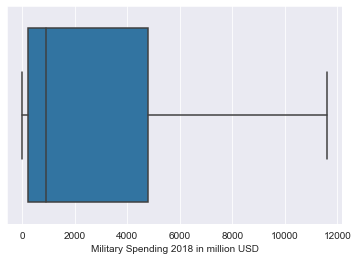

In [102]:
plotBroadBand = sns.boxplot(x=dataset['MilitarySpending2018'], showfliers= False)
#plotBroadBand = sns.swarmplot(x=dataset['MilitarySpending2018'], color="r")
plotBroadBand.set(
    xlabel='Military Spending 2018 in million USD'
)
plotBroadBand.get_figure().savefig(r'..\output\Military Spending Boxplot.png')
plt.show()

50 % der Länder haben Militärausgaben zwischen ~100 und ~4900 Mio. USD.

<a id='scatterplots'></a>
# 13. Scatterplots
Im Folgenden wurden Scatterplots erstellt, um eine Korrelation zwischen den einzelnen Datensätzen darzustellen. Dabei stellt jeder Punkt im Graph eine Land dar. Die Linie zeigt den Mittelwert an.

<a id='gdp_broadband_speed'></a>
# 13.1 GDP - Broadband Speed (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
Hier wird der GDP in Milliarden (Englisch Milliarden = Billion) USD mit der Breitbandgeschwindigkeit in Mbps (Megabytes per second) vergleichen. Hierbei wird geprüft, ob eine Korrelation zwischen den Daten besteht.

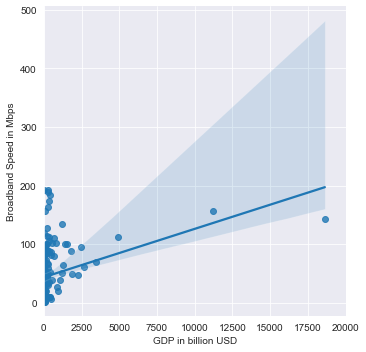

In [103]:
plotBroadBand = sns.lmplot(x="GDP", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('GDP in billion USD')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plt.xlim(0, 20000)
plotBroadBand.savefig(r'..\output\GDP - Broadband Speed.png')
plt.show()

Die Grafik zeigt eine positive Korrelation zwischen den Daten. Im Durchschnitt steigt die Breitbandgeschwindigkeit, wenn der GDP höher ist. Auffällig sind hier Länder, die einen Extrem hohen GDP haben, aber nicht die höchste Breitbandgeschwindigkeit. In diesen Bereich fallen z.B. die USA, China und auch Deutschland. Das zeigt, dass ein höherer GDP zwar mit einer höheren Breitbandgeschwindigkeit zusammenhängt, aber nicht 1:1 korrelieren.

<a id='gdp_mobile_speed'></a>
# 13.2 GDP - Mobile Speed (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
Hier wird der GDP in Milliarden (Englisch Milliarden = Billion) USD mit der mobilen Internetgeschwindigkeit in Mbps vergleichen. Hierbei wird geprüft, ob eine Korrelation zwischen den Daten besteht.

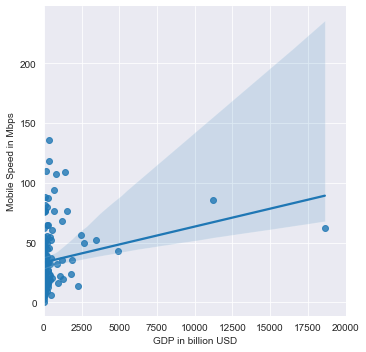

In [104]:
plotBroadBand = sns.lmplot(x="GDP", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('GDP in billion USD')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plt.xlim(0, 20000)
plotBroadBand.savefig(r'..\output\GDP - Mobile Speed.png')
plt.show()

Die Grafik zeigt eine positive Korrelation zwischen den Daten. Im Durchschnitt steigt die mobile Internetgeschwindigkeit, wenn der GDP höher ist. Wie bei der Breitbandgeschwindigkeit bereits sind die Länder mit extrem hohem GDP auffällig. Auch hier haben diese Länder nicht die höchste mobile Internetgeschwindigkeit, wenn sie den höchsten GDP haben.

<a id='internet_access_mobile_speed'></a>
# 13.3 Internet Access - Mobile Speed (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
In diesem Scatterplot wird der Internet Access in % mit der mobilen Internetgeschwindigkeit in Mbps verglichen. Hierbei wird geprüft, ob eine Korrelation zwischen den Daten besteht.

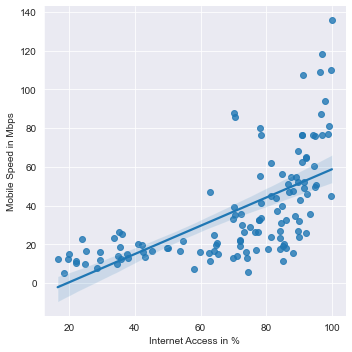

In [105]:
plotBroadBand = sns.lmplot(x="InternetAccess2020", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('Internet Access in %')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plotBroadBand.savefig(r'..\output\Internet Access - Mobile Speed.png')
plt.show()

Die Grafik zeigt eine positive Korrelation zwischen den Daten. Im Durchschnitt ist die mobile Internetgeschwindigkeit höher, wenn der Internet Access höher ist. Auffällig sind hier vor allem die gegen Ende sehr breit gefächerten Unterschiede zwischen den einzelnen Ländern im Mobile Speed bei gleichem Internet Access. Ab ca. 60% Internet Access beginnen diese Unterschiede.

<a id='internet_access_broadband_speed'></a>
# 13.4 Internet Access - Broadband Speed (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
In diesem Scatterplot wird der Internet Access in % mit der Breitbandgeschwindigkeit in Mbps verglichen. Hierbei wird geprüft, ob eine Korrelation zwischen den Daten besteht.


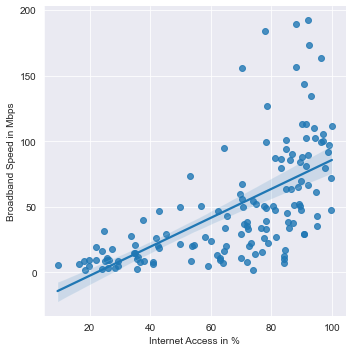

In [106]:
plotBroadBand = sns.lmplot(x="InternetAccess2020", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('Internet Access in %')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plotBroadBand.savefig(r'..\output\Internet Access - Broadband Speed.png')
plt.show()

Die Grafik zeigt eine positive Korrelation zwischen den Daten. Im Durchschnitt ist die Breitbandgeschwindigkeit höher, wenn der Internet Access höher ist. Besonders auffällig sind die extremen Unterschiede in der Breitbandgeschwindigkeit bei gleichem Internet Access. So sind manche Länder bei einem Internet Access von über 80 % und haben dennoch eine Breitbandgeschwindigkeit von ca. 10 Mbps, während andere Länder mit gleichem Internet Access bei einer Breitbandgeschwindigkeit von ca. 180 Mbps sind.

<a id='unemployment_mobile_speed'></a>
# 13.5 Unemployment - Mobile Speed (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
In diesem Scatterplot wird der Arbeitslosenquote in % mit der mobilen Internetgeschwindigkeit in Mbps verglichen. Hierbei wird geprüft, ob eine Korrelation zwischen den Daten besteht.

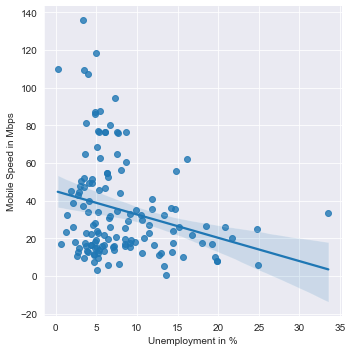

In [107]:
plotBroadBand = sns.lmplot(x="Unemployment2021", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('Unemployment in %')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plotBroadBand.savefig(r'..\output\Unemployment - Mobile Speed.png')
plt.show()

Die Grafik zeigt eine negative Korrelation zwischen den Daten. Im Durchschnitt steigt die mobile Internetgeschwindigkeit, wenn die Arbeitslosenquote sinkt. Die größte Ansammlung an Daten befindet sich bei ca. 5 % Unemployment. Hierbei sind viele Länder bei einem mobilen Internetgeschwindigkeit von ~20 Mbps. Dennoch sind die Unterschiede hier ebenfalls auffällig groß, so haben wir hier eine Spanne in der mobilen Intergeschwindigkeit von 2 bis 135 Mbps, alle bei ca. 5 % Unemployment.

<a id='unemployment_broadband_speed'></a>
# 13.6 Unemployment - Broadband Speed (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
In diesem Scatterplot wird der Arbeitslosenquote in % mit der Breitbandgeschwindigkeit in Mbps verglichen. Hierbei wird geprüft, ob eine Korrelation zwischen den Daten besteht.

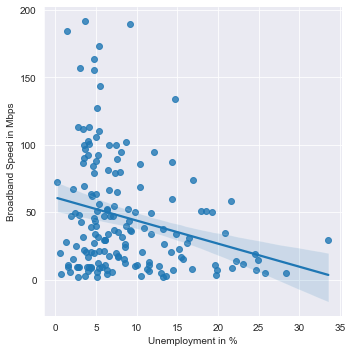

In [108]:
plotBroadBand = sns.lmplot(x="Unemployment2021", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('Unemployment in %')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plotBroadBand.savefig(r'..\output\Unemployment - Broadband Speed.png')
plt.show()

Die Grafik zeigt eine negative Korrelation zwischen den Daten. Im Durchschnitt steigt die Breitbandgeschwindigkeit, wenn die Arbeitslosenquote sinkt. Wie bereits bei der mobilen Internetgeschwindigkeit sind auch hier die extremen Unterschiede in der Breitbandgeschwindigkeit bei gleicher Unemployment sehr auffällig. Ebenfalls bei ca. 5 % unemployment liegt die Breitbandgeschwindigkeit in einer Spanne von fast 0 bis ca. 190 Mbps.

<a id='military_spending_broadband_speed'></a>
# 13.7 Military Spending - Broadband Speed (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
In diesem Scatterplot wird das Military Spending in Millionen USD mit der Breitbandgeschwindigkeit in Mbps verglichen. Hierbei wird geprüft, ob eine Korrelation zwischen den Daten besteht.

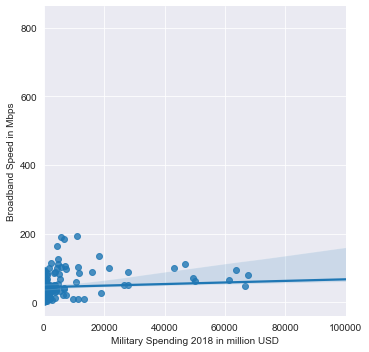

In [109]:
plotBroadBand = sns.lmplot(x="MilitarySpending2018", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('Military Spending 2018 in million USD')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plt.xlim(0, 100000) #Ohne USA
plotBroadBand.savefig(r'..\output\Military Spending - Broadband Speed.png')
plt.show()

Die Grafik zeigt eine sehr leicht positive Korrelation zwischen den Daten. Im Durchschnitt steigt die Breitbandgeschwindigkeit leicht, wenn das Military Spending höher ist. Da die Korrelation nur sehr leicht zu sehen ist, hat dieser Faktor vermutlich fast keinen einflussreichen Effekt auf die Breitbandgeschwindigkeit.

<a id='military_spending_mobile_speed'></a>
# 13.8 Military Spending - Mobile Speed (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
In diesem Scatterplot wird die Military Spending in Millionen USD mit der mobilen Internetgeschwindigkeit in Mbps verglichen. Hierbei wird geprüft, ob eine Korrelation zwischen den Daten besteht.

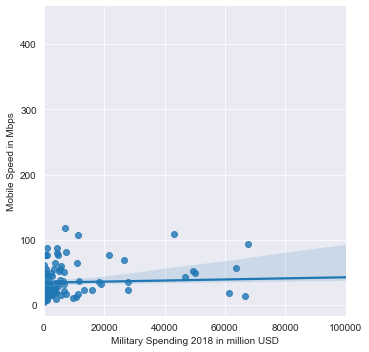

In [110]:
plotBroadBand = sns.lmplot(x="MilitarySpending2018", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('Military Spending 2018 in million USD')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plt.xlim(0, 100000) #Ohne USA
plotBroadBand.savefig(r'..\output\Military Spending - Mobile Speed.png')
plt.show()

Die Grafik zeigt eine sehr leicht positive Korrelation zwischen den Daten. Im Durchschnitt steigt die mobile Internetgeschwindigkeit leicht, wenn das Military Spending höher ist. Da die Korrelation hier wie bei der Breitbandgeschwindigkeit nur sehr leicht vorhanden ist, hat der Faktor auch hier fast keinen einflussreichen Effekt auf die mobile Internetgeschwindigkeit.

<a id='happiness_score_mobile_speed'></a>
# 13.9 Happiness Score - Mobile Speed (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
In diesem Scatterplot wird der Happiness Score mit der mobilen Internetgeschwindigkeit in Mbps verglichen. Hierbei wird geprüft, ob eine Korrelation zwischen den Daten besteht.

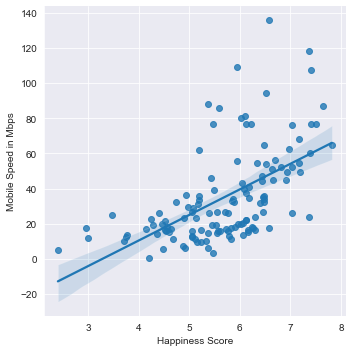

In [111]:
plotBroadBand = sns.lmplot(x="HappinessScore2022", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('Happiness Score')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plotBroadBand.savefig(r'..\output\Happiness Score - Mobile Speed.png')
plt.show()

Die Grafik zeigt eine starke Korrelation zwischen den Daten. So steigt die mobile Internetgeschwindigkeit, wenn der Happiness Score höher ist. Vermutlich ist der Effekt andersrum eher ausschlaggebend, so wird vermutlich der Happiness Score durch eine höhere mobile Internetgeschwindigkeit positiv beeinflusst.

<a id='happiness_score_broadband_speed'></a>
# 13.10 Happiness Score - Broadband Speed (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
In diesem Scatterplot wird der Happiness Score mit der Breitbandgeschwindigkeit in Mbps verglichen. Hierbei wird geprüft, ob eine Korrelation zwischen den Daten besteht.


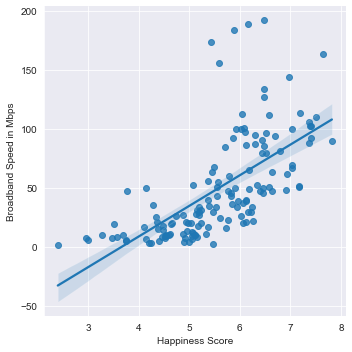

In [112]:
plotBroadBand = sns.lmplot(x="HappinessScore2022", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('Happiness Score')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plotBroadBand.savefig(r'..\output\Happiness Score - Broadband Speed.png')
plt.show()

Die Grafik zeigt eine starke Korrelation zwischen den Daten. So steigt die Breitbandgeschwindigkeit, wenn der Happiness Score höher ist. Wie bereits in den zuvor beschriebenen Graphen sind hier die Unterschiede in der Breitbandgeschwindigkeit bei gleichem Happiness Score auffällig.

<a id='unemployment_internet_access'></a>
# 13.11 Unemployment - Internet Access (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)

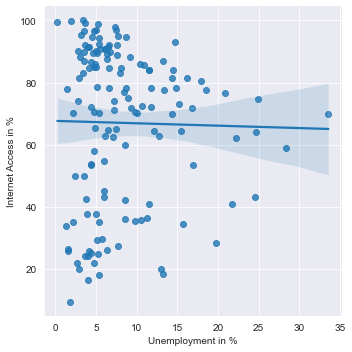

In [113]:
plotBroadBand = sns.lmplot(x="Unemployment2021", y="InternetAccess2020", data=dataset)
plotBroadBand.set_xlabels('Unemployment in %')
plotBroadBand.set_ylabels('Internet Access in %')
plotBroadBand.savefig(r'..\output\Unemployment - Internet Access.png')
plt.show()

Die Grafik zeigt eine leicht negative Korrelation zwischen den Daten. Sinkt die Arbeitslosenquote, so steigt der Internet Access. Auffällig sind hier die großen Unterschiede im Internet Access trotz gleicher Arbeitslosenquote. So sind die Unterschiede bei 0-5 % Arbeitslosenquote in einem Rahmen zwischen ~5 und fast 100 % Internet Access.

<a id='nan_percentage'></a>
# 14. NaN Percentage (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
Die unten zu sehende Grafik zeigt an, wie viele NaN Werte die einzelnen Datensätze haben. Bei NaN Werten handelt es sich um nicht vorhandene Werte.

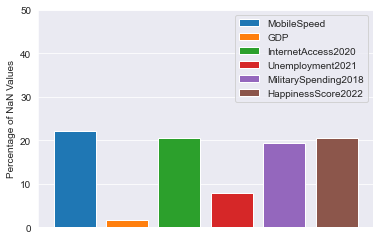

In [114]:
percent = dataset.isna().mean().round(4) * 100
f, ax = plt.subplots()
percent.drop('YearGDP', axis=0, inplace=True)

for i,item in enumerate(zip(percent.keys(),percent.values)):
    if (item[1] > 0):
        ax.bar(item[0], item[1], label = item[0])
        #ax.text(i - 0.25, item[1] + 1.5 , str(np.round(item[1],2)))

ax.set_xticklabels([])
ax.set_xticks([])
plt.ylim(0,50)
plt.ylabel('Percentage of NaN Values')
plt.legend()
plt.savefig(r'..\output\NaN Values.png')
plt.show()

In einem Balkendiagramm dargestellt sind die Prozentual vorhandenen NaN Werte pro Datensatz. So haben wir beim mobile Speed mit knapp 23 % am meisten NaN Werte, bei GDP mit ca. 2 % am wenigsten. Internet Access, Military Spending und der Happiness Score haben alle knapp über oder unter 20 % NaN Werte. Unemployment hat 7 % fehlende Werte. Broadband Speed ist in diesem Diagramm nicht vorhanden, da alle Daten vorhanden sind.

<a id='pairplots'></a>
# 15. Pairplots
Bei Pairplots handel es sich um eine Matrix aus Scatterplots. Es soll die Korrelationen zwischen den einzelnen Datensätzen nochmal direkt veranschaulichen.

<a id='pailplot_mobile_speed'></a>
# 15.1 Pairplot - Mobile Speed
Im Folgenden werden nochmal alles Korrelationen der Datensätze mit der mobilen Internetgeschwindigkeit und auch untereinander in einer Matrix dargestellt.

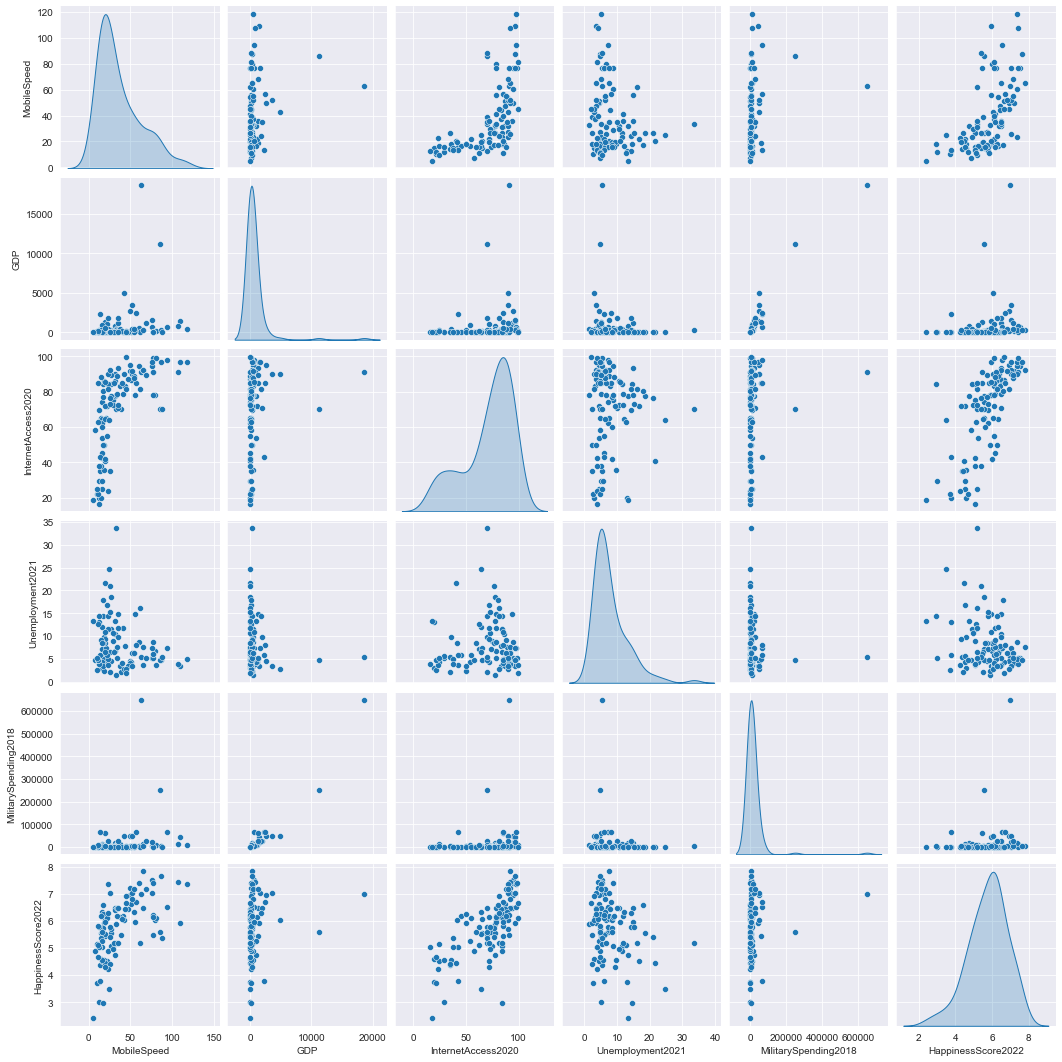

In [115]:
tmpMobile = dataset.drop('CountryCode', axis=1)
tmpMobile.drop('CountryName', axis=1, inplace=True)
tmpMobile.drop('YearGDP', axis=1, inplace=True)
tmpMobile.drop('YearInternetSpeed', axis=1, inplace=True)
tmpMobile.drop('BroadbandSpeed', axis=1, inplace=True)

tmpMobile = tmpMobile.dropna()

plot = sns.pairplot(tmpMobile[['MobileSpeed', 'GDP', 'InternetAccess2020', 'Unemployment2021', 'MilitarySpending2018', 'HappinessScore2022']], diag_kind='kde')
plot.savefig(r'..\output\Mobile Speed - Pair plot.png')
plt.show()

# (Grafik darüber beschreiben und als Unterpunkt der Gliederung hinzufügen)

<a id='pairplot_broadband_speed'></a>
# 15.2 Pairplot - Broadband Speed (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
Im Folgenden werden nochmal alles Korrelationen der Datensätze mit der Breitbandgeschwindigkeit und auch untereinander in einer Matrix dargestellt.

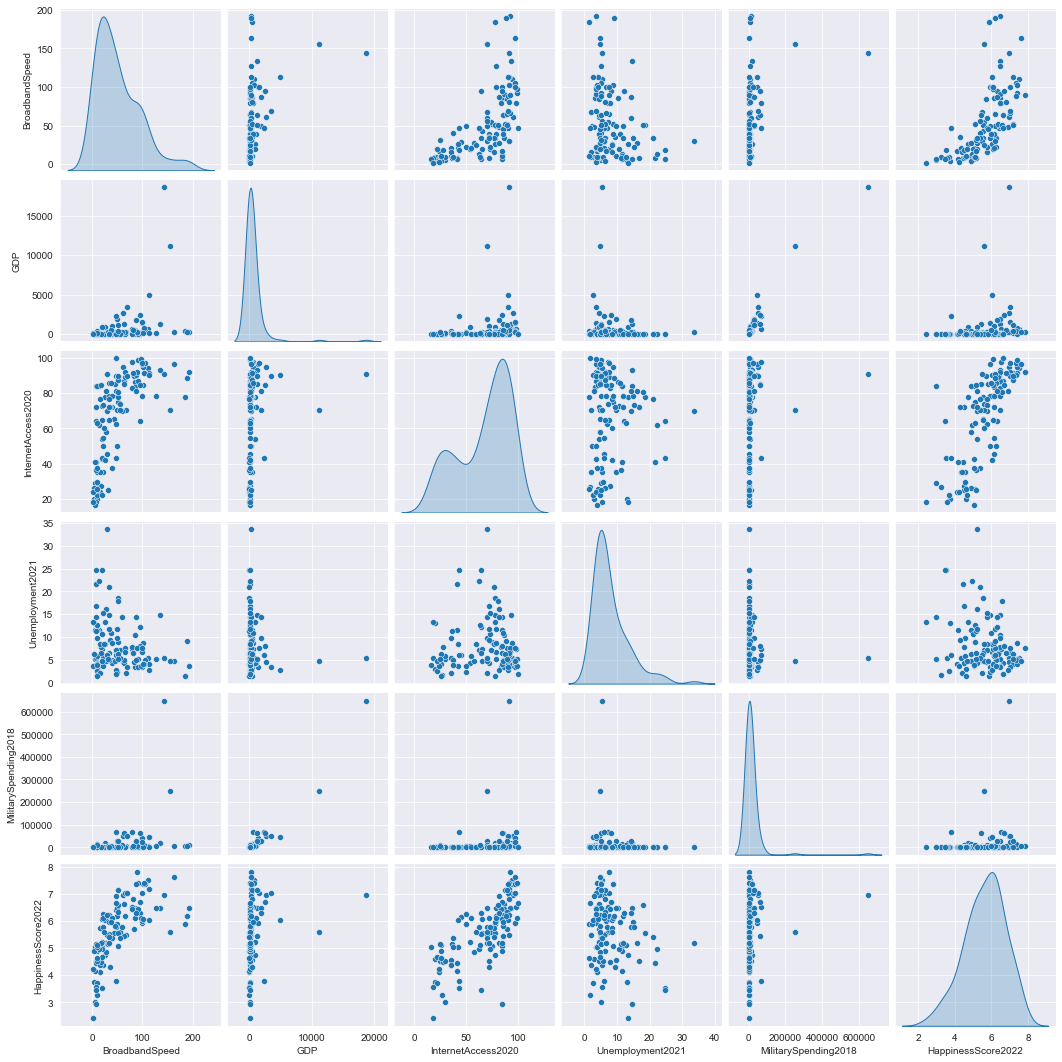

In [116]:
tmpBroadband = dataset.drop('CountryCode', axis=1)
tmpBroadband.drop('CountryName', axis=1, inplace=True)
tmpBroadband.drop('YearGDP', axis=1, inplace=True)
tmpBroadband.drop('YearInternetSpeed', axis=1, inplace=True)
tmpBroadband.drop('MobileSpeed', axis=1, inplace=True)

tmpBroadband = tmpBroadband.dropna()

plot = sns.pairplot(tmpBroadband[['BroadbandSpeed', 'GDP', 'InternetAccess2020', 'Unemployment2021', 'MilitarySpending2018', 'HappinessScore2022']], diag_kind='kde')
plot.savefig(r'..\output\Broadband Speed - Pair plot')
plt.show()

# (Grafik darüber beschreiben und als Unterpunkt der Gliederung hinzufügen)

<a id='adjusting_tmpmobile'></a>
# 16. Adjusting tmpMobile

In [117]:
average = tmpMobile['MobileSpeed'].mean()
tmpMobile.insert(0, 'OverAverage', np.where(tmpMobile['MobileSpeed'] > average, 1, 0))
tmpMobile.drop('MobileSpeed', axis=1, inplace=True)

<a id='adjusting_tmpbroadband'></a>
# 17. Adjusting tmpBroadband (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)

In [118]:
average = tmpBroadband['BroadbandSpeed'].mean()
tmpBroadband.insert(0, 'OverAverage', np.where(tmpBroadband['BroadbandSpeed'] > average, 1, 0))
tmpBroadband.drop('BroadbandSpeed', axis=1, inplace=True)

<a id='mobile_speed_neural_net'></a>
# 18. Mobile Speed Neural Net
In diesem Teil der Arbeit wird das neuronale Netz für die mobile Internetgeschwindigkeit trainiert und ausgeführt.

<a id='mobile_speed_deep_learning'></a>
# 18.1 Mobile Speed - Deep Learning (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)

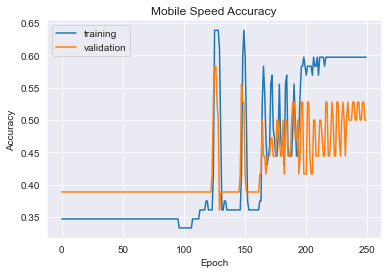

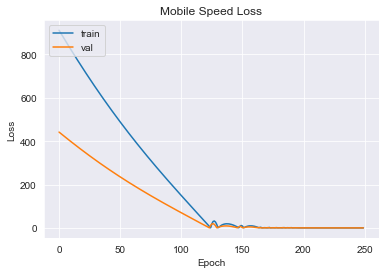

In [119]:
labels=tmpMobile['OverAverage']
features = tmpMobile.iloc[:,1:6]
X=features
y=np.ravel(labels)

opt = keras.optimizers.Adam(learning_rate=0.001)
model_mobile = Sequential()
model_mobile.add(Dense(5, activation='relu', input_shape=(5,)))
model_mobile.add(Dense(3, activation='relu'))
model_mobile.add(Dense(1, activation='sigmoid'))
model_mobile.compile(loss='binary_crossentropy',
optimizer=opt,
metrics=['accuracy'])
training_mobile = model_mobile.fit(X, y,epochs=250, batch_size=128, verbose=0, shuffle=True, validation_split=0.33)


plt.plot(training_mobile.history['accuracy'])
plt.plot(training_mobile.history['val_accuracy'])
plt.title('Mobile Speed Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.savefig(r'..\output\Mobile Speed - Accuracy.png')
plt.show()



plt.plot(training_mobile.history['loss'])
plt.plot(training_mobile.history['val_loss'])
plt.title('Mobile Speed Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(r'..\output\Mobile Speed - Loss.png')
plt.show()

# (Grafik darüber beschreiben und als Unterpunkt der Gliederung hinzufügen)

<a id='mobile_speed_over_average'></a>
# 18.2 Mobile Speed - Over Average (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)

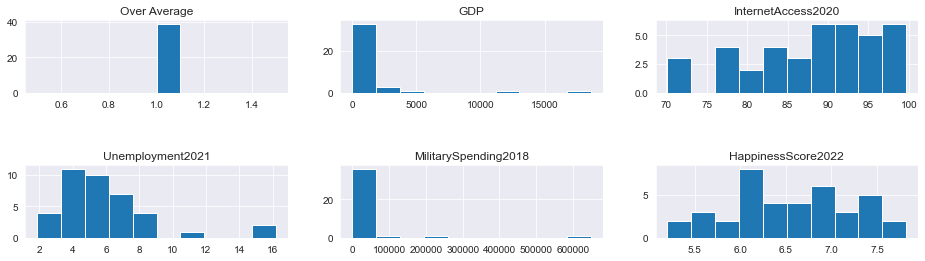

In [120]:
df = pd.DataFrame(tmpMobile, columns= np.array(tmpMobile.columns))
overAverage = df.loc[(df.OverAverage == 1)]
fig, ax = plt.subplots(2,3,figsize=(16, 4) )
i = 0
j = 0
for c in overAverage.columns[0:]:
    ax[j,i].hist(overAverage[c])
    ax[j,i].set_title(c)
    i = i + 1
    if i == 3:
        j = 1
        i = 0
ax[0,0].set_title("Over Average")
fig.subplots_adjust(hspace=1, wspace=0.2)


plt.savefig(r'..\output\Mobile Speed - Over Average.png')
plt.show()

<a id='mobile_speeds_under_average'></a>
# 18.3 Mobile Speeds - Under Average (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)

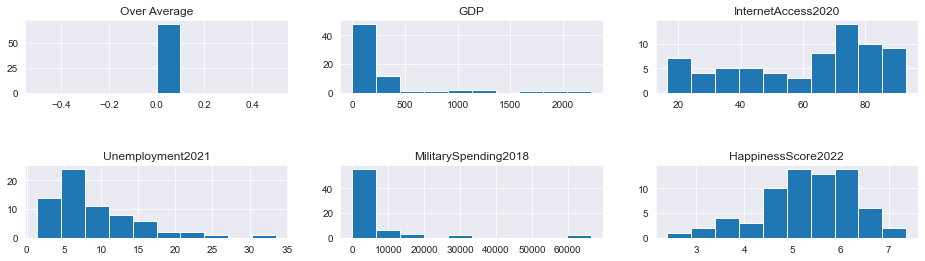

In [121]:
df = pd.DataFrame(tmpMobile, columns= np.array(tmpMobile.columns))
overAverage = df.loc[(df.OverAverage == 0)]
fig, ax = plt.subplots(2,3,figsize=(16, 4) )
i = 0
j = 0
for c in overAverage.columns[0:]:
    ax[j,i].hist(overAverage[c])
    ax[j,i].set_title(c)
    i = i + 1
    if i == 3:
        j = 1
        i = 0
ax[0,0].set_title("Over Average")
fig.subplots_adjust(hspace=1, wspace=0.2)


plt.savefig(r'..\output\Mobile Speed - Under Average.png')
plt.show()

# (Grafik darüber beschreiben und als Unterpunkt der Gliederung hinzufügen)

<a id='vergleich_mobile_speed_over_average_under_average'></a>
# 18.4 Vergleich Mobile Speed Over Average / Under Average

<a id='mobile_speed_neural_network_visualisation'></a>
# 18.5 Mobile Speed - Neural Network Visualization (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)

Hier wird die Funktion vom Anfang aufgerufen, um das erstellte neuronale Netzwerk Grafisch darzustellen, für genauere Informationen wie dies geschieht /LinkZurFunktion/

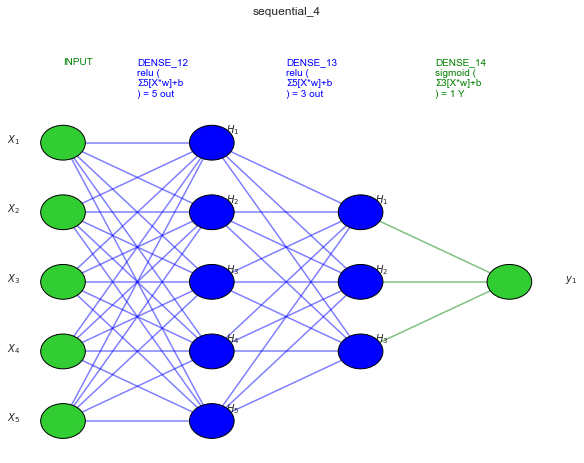

In [122]:
visualize_nn(model_mobile, 'Mobile Speed - Neural Network', description=True, figsize=(10,8))

# (Grafik darüber beschreiben und als Unterpunkt der Gliederung hinzufügen)

<a id='broadband_speed_neural_net'></a>
# 19. Broadband Speed Neural Net


<a id='broadband_speed_deep_learning'></a>
# 19.1 Broadband Speed - Deep Learning (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)

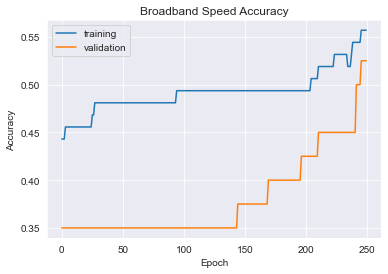

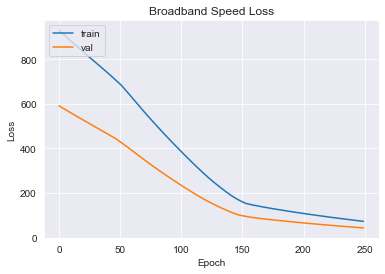

In [123]:
labels=tmpBroadband['OverAverage']
features = tmpBroadband.iloc[:,1:6]
X=features
y=np.ravel(labels)

opt = keras.optimizers.Adam(learning_rate=0.001)
model_broadband = Sequential()
model_broadband.add(Dense(5, activation='relu', input_shape=(5,)))
model_broadband.add(Dense(3, activation='relu'))
model_broadband.add(Dense(1, activation='sigmoid'))
model_broadband.compile(loss='binary_crossentropy',
optimizer=opt,
metrics=['accuracy'])
training_broadband = model_broadband.fit(X, y,epochs=250, batch_size=128, verbose=0, shuffle=True, validation_split=0.33)


plt.plot(training_broadband.history['accuracy'])
plt.plot(training_broadband.history['val_accuracy'])
plt.title('Broadband Speed Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.savefig(r'..\output\Broadband Speed - Accuracy.png')
plt.show()



plt.plot(training_broadband.history['loss'])
plt.plot(training_broadband.history['val_loss'])
plt.title('Broadband Speed Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(r'..\output\Broadband Speed - Loss.png')
plt.show()

# (Grafik darüber beschreiben und als Unterpunkt der Gliederung hinzufügen)

<a id='broadband_speed_over_average'></a>
# 19.2 Broadband Speed - Over Average (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)

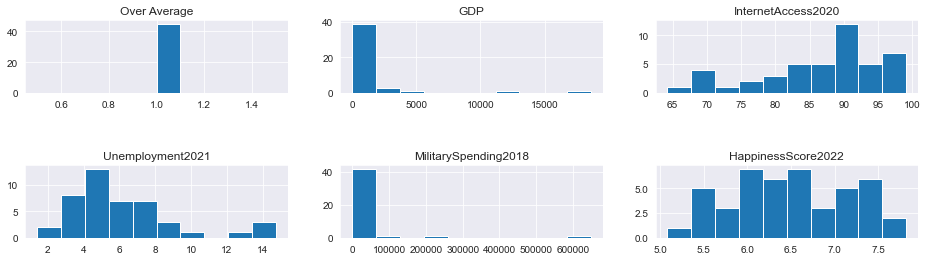

In [124]:
df = pd.DataFrame(tmpBroadband, columns= np.array(tmpBroadband.columns))
overAverage = df.loc[(df.OverAverage == 1)]
fig, ax = plt.subplots(2,3,figsize=(16, 4) )
i = 0
j = 0
for c in overAverage.columns[0:]:
    ax[j,i].hist(overAverage[c])
    ax[j,i].set_title(c)
    i = i + 1
    if i == 3:
        j = 1
        i = 0
ax[0,0].set_title("Over Average")
fig.subplots_adjust(hspace=1, wspace=0.2)


plt.savefig(r'..\output\Broadband Speed - Over Average.png')
plt.show()

# (Grafik darüber beschreiben und als Unterpunkt der Gliederung hinzufügen)

<a id='broadband_speed_under_average'></a>
# 19.3 Broadband Speed - Under Average (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)

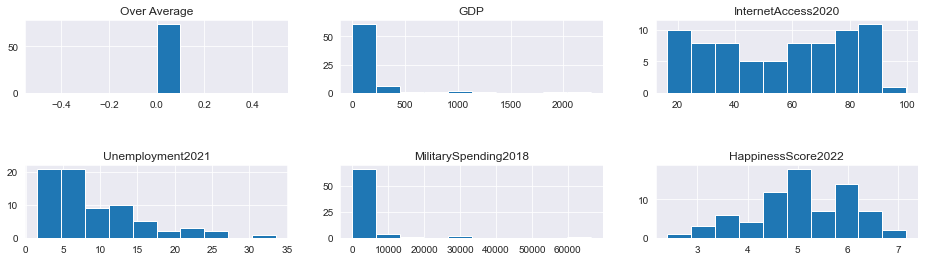

In [125]:
df = pd.DataFrame(tmpBroadband, columns= np.array(tmpBroadband.columns))
overAverage = df.loc[(df.OverAverage == 0)]
fig, ax = plt.subplots(2,3,figsize=(16, 4) )
i = 0
j = 0
for c in overAverage.columns[0:]:
    ax[j,i].hist(overAverage[c])
    ax[j,i].set_title(c)
    i = i + 1
    if i == 3:
        j = 1
        i = 0
ax[0,0].set_title("Over Average")
fig.subplots_adjust(hspace=1, wspace=0.2)


plt.savefig(r'..\output\Broadband Speed - Under Average.png')
plt.show()

# (Grafik darüber beschreiben und als Unterpunkt der Gliederung hinzufügen)

<a id='broadband_speed_over_average'></a>
# 19.4 Vergleich Broadband Speed Over Average / Under Average

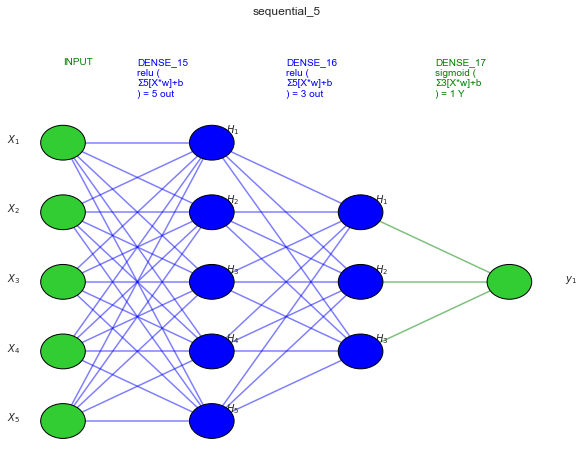

In [126]:
visualize_nn(model_broadband, 'Broadband Speed - Neural Network', description=True, figsize=(10,8))

# (Grafik darüber beschreiben und als Unterpunkt der Gliederung hinzufügen)

<a id='welt_ansichten'></a>
# 20. Welt Ansichten
In diesem letzten Abschnitt werden die Internetgeschwindigkeiten auf einer Weltkugel grafisch dargestellt. Wenn man mit dem Mauszeiger über ein Land "hovert" wird das Land und dessen Internetgeschwindigkeit angezeigt. Lässt man auf der Maus die linke Maustaste gedrückt, kann man die Weltkugel drehen.

<a id='welt_broadband_speed'></a>
# 20.1 Welt - Broadband Speed (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
Hier wird die Weltkugel mit den Breitbandgeschwindigkeiten dargestellt. Die Kugel kann nicht in output Ordner gespeichert werden.

In [127]:
internet_speed_country = dataset
internet_speed_country.reset_index()

world_broadband = px.choropleth(
    internet_speed_country,                 #Das Datenset das verwendet wird
    locations='CountryCode',                #Länder werden über die Spalte CountryCode zugeordnet
    locationmode='ISO-3',                   #Länder werden mit 3 Digit CountryCodes zugeordnet
    color='BroadbandSpeed',                 #Die Farben werden nach dem BroadbandSpeed vergeben
    color_continuous_scale= 'temps_r',      #Die Farbscala temps wird reversed verwendet
    hover_name='CountryName',               #Beim Hovern soll der Name des Landes angezeigt werden
    title = 'Boradband Speed - Worldwide')  #Die Überschrift der Karte

world_broadband.update_geos(projection_type="orthographic",
                        showocean=True,
                        showlakes=True,
                        showcountries=True,
                        lataxis_showgrid=True,
                        lonaxis_showgrid=True) #Weitere Einstellungen für die Karte

world_broadband.update_layout(height=800, margin={"r":0,"t":80,"l":0,"b":50}) #Anpassen des Layouts

world_broadband.show()  #Anzeige der Welt

# (Grafik darüber beschreiben und als Unterpunkt der Gliederung hinzufügen)

<a id='welt_mobile_speed'></a>
# 20.2 Welt - Mobile Speed (Folgenden Codeblock beschreiben und zur gliederung hinzufügen)
Hier wird die Weltkugel mit den mobilen Internetgeschwindigkeiten dargestellt. Die Kugel kann nicht in output Ordner gespeichert werden.

In [128]:
internet_speed_country = dataset
internet_speed_country.reset_index()

world_mobile = px.choropleth(
    internet_speed_country,                 #Das Datenset das verwendet wird
    locations='CountryCode',                #Länder werden über die Spalte CountryCode zugeordnet
    locationmode='ISO-3',                   #Länder werden mit 3 Digit CountryCodes zugeordnet
    color='MobileSpeed',                 #Die Farben werden nach dem BroadbandSpeed vergeben
    color_continuous_scale= 'temps_r',      #Die Farbscala temps wird reversed verwendet
    hover_name='CountryName',               #Beim Hovern soll der Name des Landes angezeigt werden
    title = 'Mobile Speed - Worldwide')  #Die Überschrift der Karte

world_mobile.update_geos(projection_type="orthographic",
                        showocean=True,
                        showlakes=True,
                        showcountries=True,
                        lataxis_showgrid=True,
                        lonaxis_showgrid=True) #Weitere Einstellungen für die Karte

world_mobile.update_layout(height=800, margin={"r":0,"t":80,"l":0,"b":50}) #Anpassen des Layouts

world_mobile.show()  #Anzeige der Welt

# (Grafik darüber beschreiben und als Unterpunkt der Gliederung hinzufügen)

<a id='quellen'></a>
# Quellen: (Zur Gliederung hinzufügen)

#### Internet Speeds:
https://www.kaggle.com/datasets/prasertk/internet-broadband-and-mobile-speeds-by-country
#### Unemployment:
https://data.worldbank.org/indicator/SL.UEM.TOTL.ZS?end=2021&name_desc=false&start=1991&view=chart
#### Military Spending:
https://www.kaggle.com/datasets/nitinsss/military-expenditure-of-countries-19602019
#### Internet Access:
https://data.worldbank.org/indicator/IT.NET.USER.ZS
#### GDP:
https://www.kaggle.com/datasets/tunguz/country-regional-and-world-gdp
#### World Happiness Report:
https://www.kaggle.com/datasets/mathurinache/world-happiness-report